In [128]:
import numpy as np
import pandas as pd
import math
%pylab inline
import warnings
import os
import pickle

from datetime import datetime, timedelta
from scipy import stats
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

Populating the interactive namespace from numpy and matplotlib


c:\users\dell\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['std', 'datetime', 'mean', 'product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Функции предобработок (с предыдущих недель)

In [129]:
# выбор тех регионов, из которых в среднем осущесвтляется больше 5 поездок
def chose_refions_with_rides(df):
    df.index = pd.to_datetime(df.index)
    
    # выделяем час из даты
    df['pickup_data'] = df.index
    df['pickup_hour'] = df['pickup_data'].dt.hour

    # число дней в месяце
    days_in_month = df['pickup_data'][0].days_in_month
    df = df.drop('pickup_data',axis = 1)
    # групируем число поездок по часам
    rides_in_hour =[]
    for i in range(0,24):
        rides_in_hour.append(df[df['pickup_hour']  == i].sum())

    df_hours = pd.DataFrame(rides_in_hour)
    df_hours = df_hours.drop('pickup_hour',axis = 1)
    
    means = df_hours.apply(np.mean)
    return np.array(means[(means/days_in_month > 5)].index)

In [130]:
# сведение всех данных в одну таблицу
def read_region_from_data(dataDir, start_year, start_month, last_year, last_month, columns):
    columns = np.append(columns,'Unnamed: 0')
    month = start_month
    year = start_year

    df = pd.DataFrame()
    while os.path.exists(dataDir + '/trip_count_%d-%02d.csv'% (year, month) ):  
        month_data = pd.read_csv(dataDir + '/trip_count_%d-%02d.csv' % (year, month), usecols = columns)       
        month_data.set_index(['Unnamed: 0'], inplace=True)
        
        df = pd.concat((df,month_data), axis = 0)

        # Return on last month and year
        if (month == last_month and year == last_year):
            df.index.name = 'time'
            df.index = pd.to_datetime(df.index)
            return df

        # Increment month
        if (month == 12):
            month = 1
            year += 1
        else:
            month += 1
        

### 2 Получение итоговой таблицы поездок
(с вычетом непопулярных регионов, определённых по маю 2016г)


In [131]:
filename = 'trip_count_2016-05.csv'
dataFolder = 'trips'
    
df = pd.read_csv(dataFolder+ '/' + filename, index_col = 0)
df.index = pd.to_datetime(df.index)
region_columns = chose_refions_with_rides(df)

In [132]:
data = read_region_from_data('trips', 2015, 8, 2016, 6, region_columns)

In [135]:
# data

### 2 Стандартизация
Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.

In [136]:
norm_mean_std = []
data_normed = data.copy()

for col in data.columns:
    mean = data_normed[col].mean()
    std = data_normed[col].std()
    norm_mean_std.append([mean, std])
                          
    data_normed[col] = (data_normed[col] - mean) / std

### 3 Кластеризация географических зон по значениям стандартизованных рядов. 

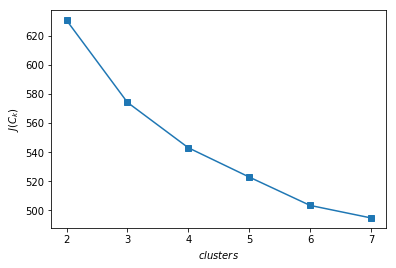

In [137]:
#для кластеризации транспонируем таблицу
data_normed_T = data_normed.T.copy()

# суммы дистанций от элементов до их соотве. кластеров
inertia = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data_normed_T)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(2, 8), inertia, marker='s');
plt.xlabel('$clusters$')
plt.ylabel('$J(C_k)$');

По графику видно, что функция быстро убывает в начале (2-3) кластера, затем это происходит менее быстро.
Выберем число кластеров, ранвое 3. Вприницпе, если вспомнить карту со второй недели, это будет оправдано.

Распределим регионы по нашим кластерам.

In [138]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit_predict(data_normed_T)

data_normed_T['cluster'] = kmeans.labels_
data_normed_T['cluster'].value_counts()

0    53
2    26
1    23
Name: cluster, dtype: int64

А теперь разобъём наш датафрейм по кластерам для дальнейшей работы по-отдельности

In [139]:
df_clusters = []

for n in range(n_clusters):
    df_clusters.append(data_normed_T[data_normed_T['cluster'] == n].T)

Убедимся, что данные по кластерам схожи.

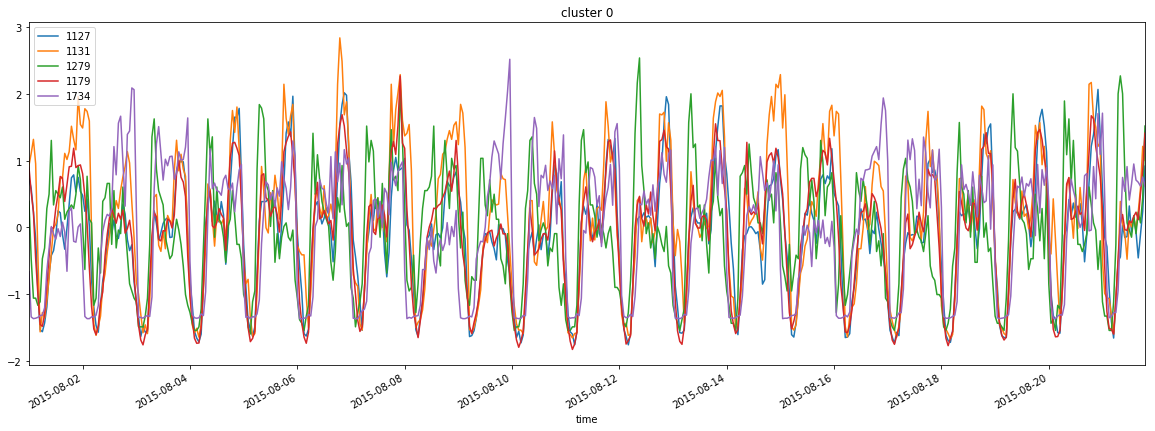

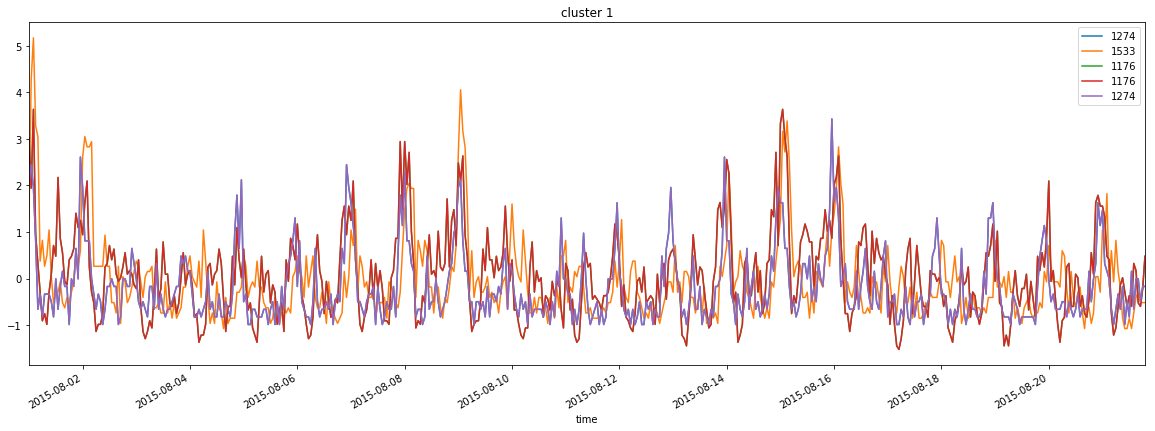

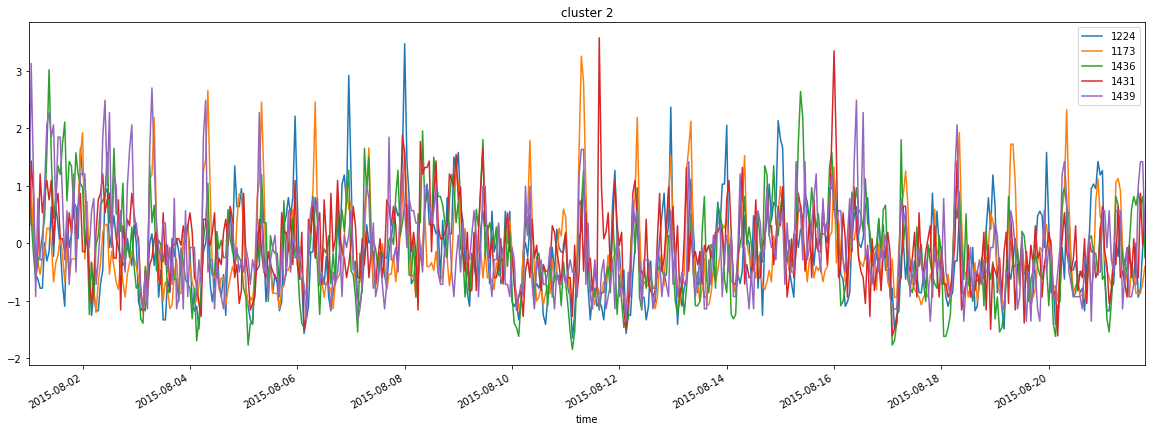

In [140]:
for i in range(n_clusters):
    columns = df_clusters[i].columns
    usecols = np.random.choice(columns, 5)
        
    df_clusters[i][usecols][0:500].plot(figsize =(20,7))
    plt.title('cluster ' + str(i))
    plt.show()

Как видно, разница между кластерами есть, внутри структура более-менее одинаковая

### 4 В каждом кластере выберем наиболее типичный ряд 
(возьмём ряд, соответствующий центру кластера)

In [141]:
df_cluster_centers = pd.DataFrame(index=data_normed.index)
for i in range(n_clusters):
    df_cluster_centers['cluster' + str(i)] = kmeans.cluster_centers_[i]
    
df_cluster_centers.head()

,cluster0,cluster1,cluster2
time,,,
2015-08-01 00:00:00,0.089974,2.301772,1.025418
2015-08-01 01:00:00,-0.374072,2.713114,1.107572
2015-08-01 02:00:00,-0.736344,2.442718,0.394063
2015-08-01 03:00:00,-0.941814,1.322652,-0.220284
2015-08-01 04:00:00,-1.162151,0.530653,0.068129


вспомогательные функции для построения модели

In [142]:
# для удаления недельных трендов
def add_week_cycle_features(original_dataframe, k, inplace=False):
    if inplace:
        df = original_dataframe
    else:
        df = original_dataframe.copy()
    T = original_dataframe.shape[0]
    for i in range(1, k + 1):
        df["s_" + str(i)] = np.sin(np.array(range(1, T + 1)) * 2. * np.pi * float(i) / 168.)
        df["c_" + str(i)] = np.cos(np.array(range(1, T + 1)) * 2. * np.pi * float(i) / 168.)
    if not inplace:
        return df

In [143]:
# признаки, отвечающие за дни недели
def add_day_of_week_features(original_dataframe, k, inplace=False):
    if inplace:
        df = original_dataframe
    else:
        df = original_dataframe.copy()
        
    for dow in range(7):
        df['dow_%d' % dow] = 0
        df.loc[df.index.dayofweek == dow, ['dow_%d' % dow]] = 1
        
    if not inplace:
        return df      

In [144]:
# разбиение данных
def split_data(df_region):
    cols = df_region.columns[1:]
    X = df_region[cols].values
    y = df_region['trips'].values  
    return X,y,cols

In [145]:
# огбучение модели Линейной регрессии
def train_lr(X,y):
    model = LinearRegression()
    model.fit(X, y)
    return model

https://www.researchgate.net/post/What_is_the_AIC_formula

In [146]:
# вычисление AIC
def calc_AIC(model, X, y, k, N):
    y_pred = model.predict(X)
    resid = y - y_pred
    sse = sum(resid ** 2)
    AIC = 2 * k + N * np.log(sse / N)
    return AIC

In [147]:
# общая функция создания регрессионных признаков
def make_regression_features(df_region):
    
    T = df_region.shape[0]

    best_aic = float("inf")
    best_cols = []
    best_k = 2
    aics = []

    for k in range(4,7):

        # regression features
        add_week_cycle_features(df_region, k, inplace = True)
        add_day_of_week_features(df_region, k, inplace = True)
        X,y,cols = split_data(df_region)
        
        # model
        lr_model = train_lr(X,y)

        # Calc AIC
        N = T        
        AIC = calc_AIC(lr_model,X,y, k, N)

        if AIC < best_aic:
            best_aic = AIC
            best_cols = cols.copy()
            best_k = k

        aics.append(AIC)

    print("Best AIC = %.4f" % best_aic)
    print("Best K = %d" % best_k)
    print("Best columns = %s" % best_cols)
    
    return best_k, best_cols

In [148]:
df_regions = []
best_ks = []
best_columns = []

for n in range(n_clusters):
    df_region = pd.DataFrame(df_cluster_centers['cluster%d'%n].copy(), index = df_cluster_centers.index)
    df_region.columns = ['trips']

    # формальность, ибо какое К не задавай, он выбирает его, так что по сути best_cols = cols.
    best_k, best_cols = make_regression_features(df_region)

    df_regions.append(df_region)
    best_ks.append(best_k)
    best_columns.append(best_cols)

Best AIC = -4005.7856
Best K = 6
Best columns = Index(['s_1', 'c_1', 's_2', 'c_2', 's_3', 'c_3', 's_4', 'c_4', 'dow_0',
       'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 's_5', 'c_5',
       's_6', 'c_6'],
      dtype='object')
Best AIC = -5665.7006
Best K = 6
Best columns = Index(['s_1', 'c_1', 's_2', 'c_2', 's_3', 'c_3', 's_4', 'c_4', 'dow_0',
       'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 's_5', 'c_5',
       's_6', 'c_6'],
      dtype='object')
Best AIC = -6935.7288
Best K = 6
Best columns = Index(['s_1', 'c_1', 's_2', 'c_2', 's_3', 'c_3', 's_4', 'c_4', 'dow_0',
       'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 's_5', 'c_5',
       's_6', 'c_6'],
      dtype='object')


In [149]:
# построение остатков для ряда (апрель)
def make_residuals(df, best_cols, begin_time, end_time):
    
    lr_model = train_lr(df[best_cols].values, df['trips'].values)

    predictions = lr_model.predict(df[best_cols])
    resid = df['trips'].values - predictions

    plt.figure(figsize=(20,7))
    
    # ogigin data
    df.loc[begin_time : end_time,'trips'].plot(label='origin_trips')   
    
    # resids
    df_resid = pd.DataFrame(resid, columns=['residuals'], index=df.index)
    df_resid.loc[begin_time : end_time,'residuals'].plot(color='y')

    # predictions
    df_pred = pd.DataFrame(predictions, columns=['predictions'], index=df.index)
    df_pred.loc[begin_time : end_time, 'predictions'].plot(color='r')

    sm.tsa.seasonal_decompose(df.loc[begin_time : end_time,'trips']).trend.plot(label = 'season_decompose')
    plt.legend(loc=1,prop={'size':16})
    return df_resid, df_pred

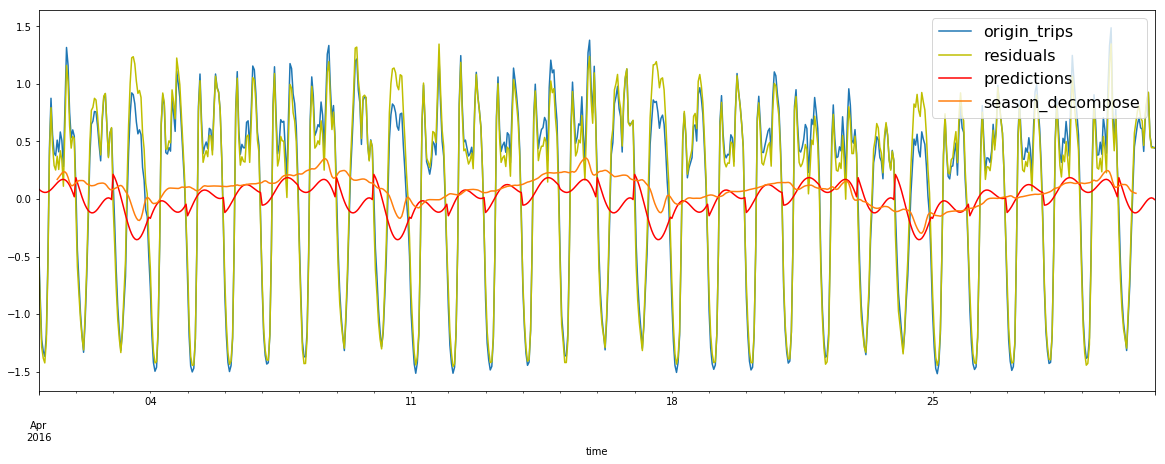

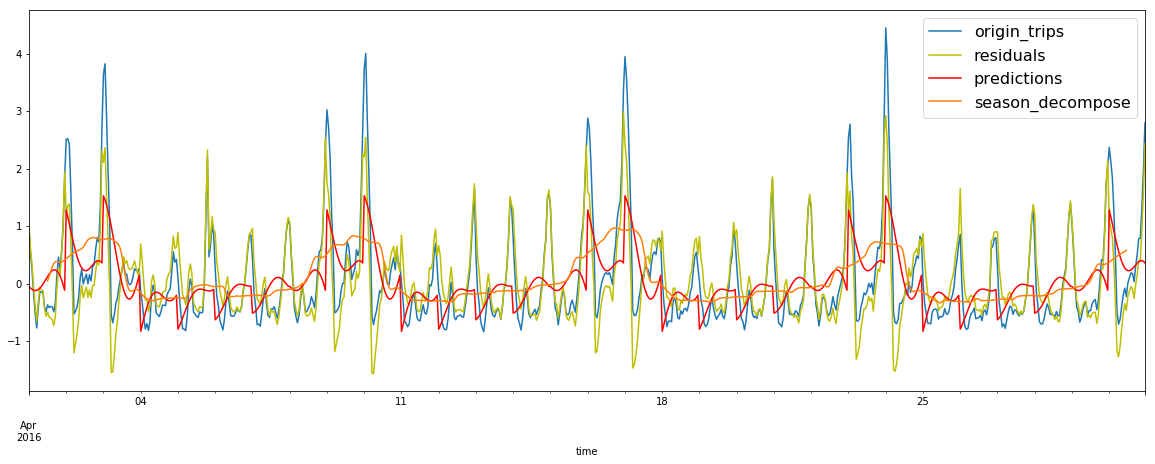

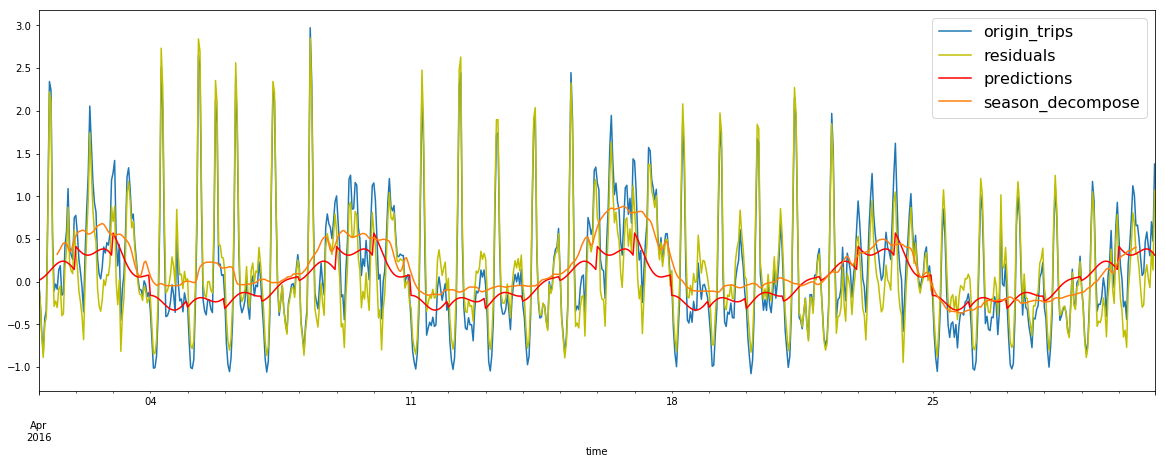

In [150]:
residuals = []
predictions = []
for n_cluster in range(n_clusters):
    begin_time = '2016-04-01 00:00:00'
    end_time = '2016-04-30 23:00:00'
    resids, preds = make_residuals(df_regions[n_cluster], best_columns[n_cluster], begin_time, end_time)
    
    residuals.append(resids)
    predictions.append(preds)

По графикам видно, что линейная регрессия неплохо описывает STL декомпозицию.

Проведём сезонное дифференцирование. Как показывала 3 неделя, одного преобразования было достаточно для получения стационарного ряда.

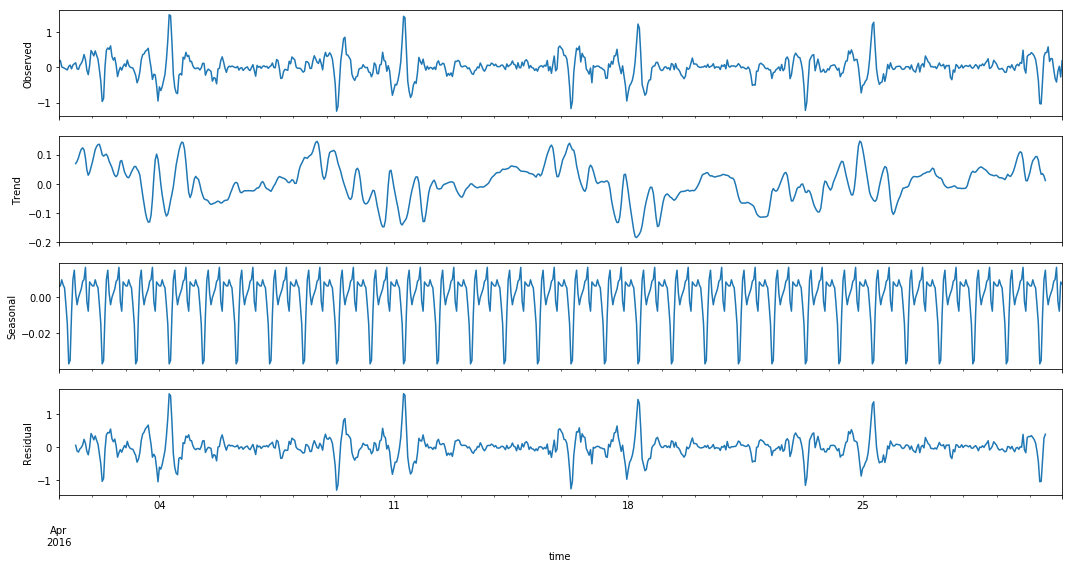

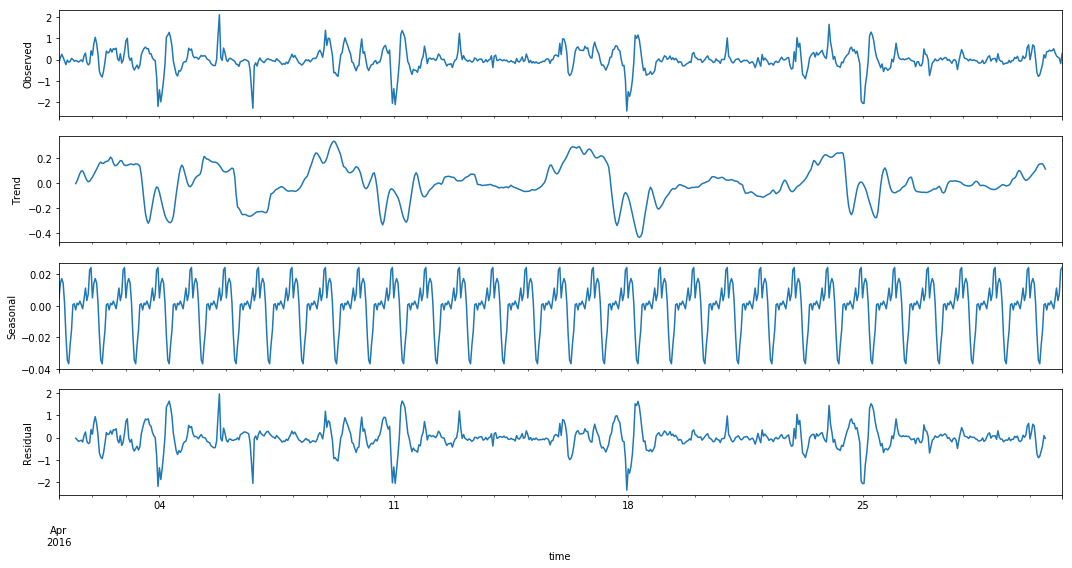

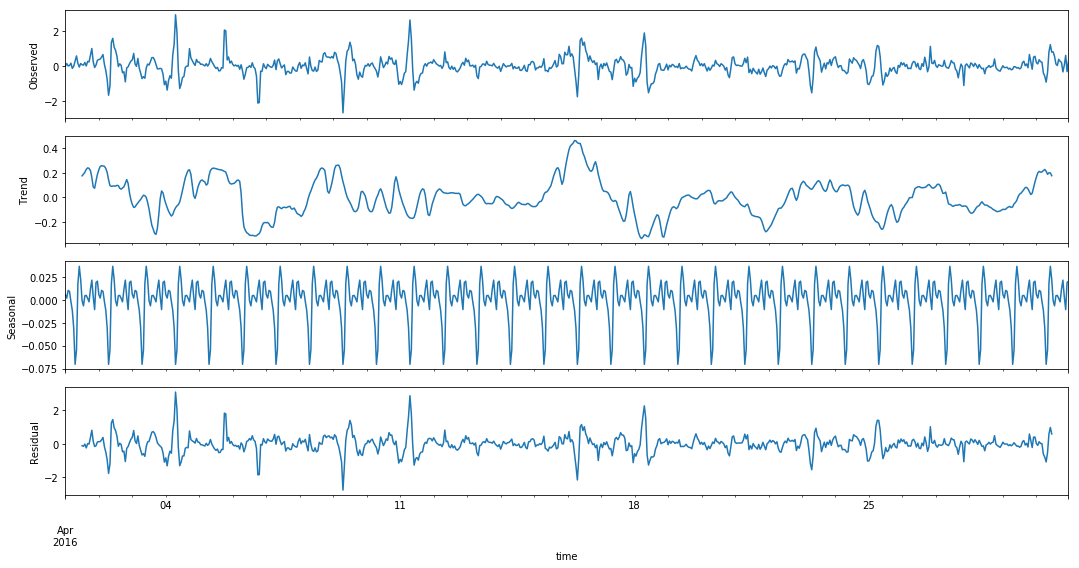

In [151]:
def make_season_diff(df_resid, begin_time, end_time):
    df_resid['diff_24'] = df_resid.residuals - df_resid.residuals.shift(24)

    plt.figure(figsize(15,8))
    sm.tsa.seasonal_decompose(df_resid.loc[begin_time:end_time,'diff_24']).plot()
    plt.show()
    
    return df_resid
    
residuals_diff24 = []
for n in range(n_clusters):
    resid_diff24 = make_season_diff(residuals[n],begin_time,end_time )
    residuals_diff24.append(resid_diff24)

In [152]:
def plot_acf_pacf(df):
    plt.figure(figsize=(15,8))
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf(df['diff_24'][24:].values.squeeze(), lags=168, ax=ax)
    plt.show()
    
    plt.figure(figsize=(15,8))
    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(df['diff_24'][24:].values.squeeze(), lags=168, ax=ax)
    plt.show()

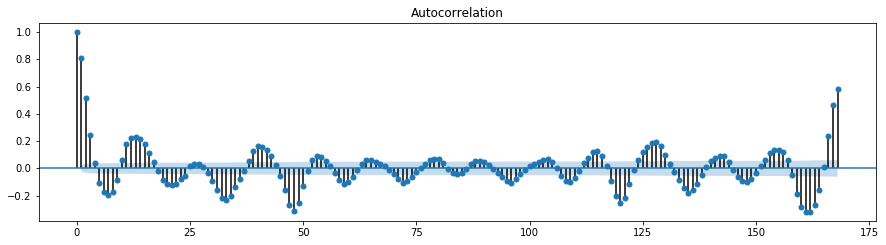

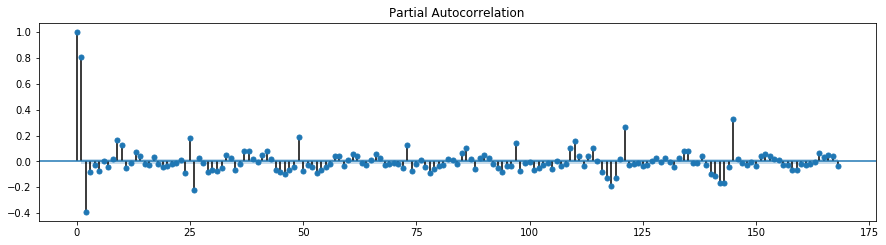

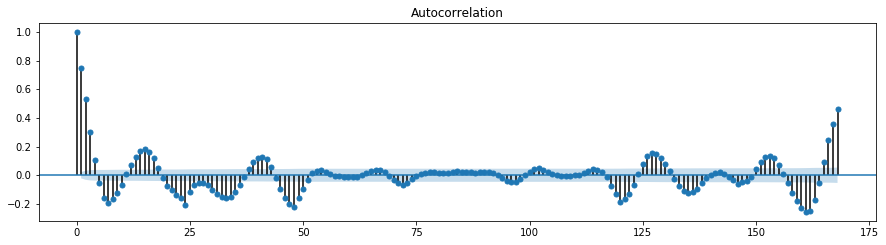

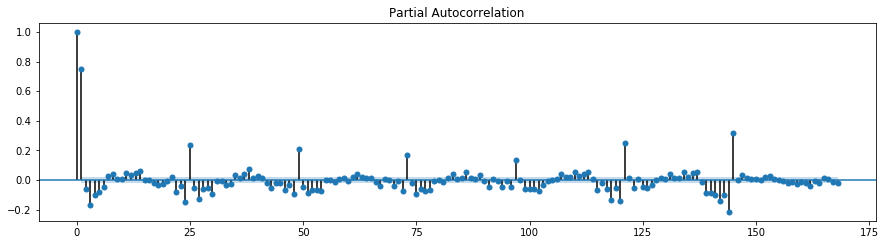

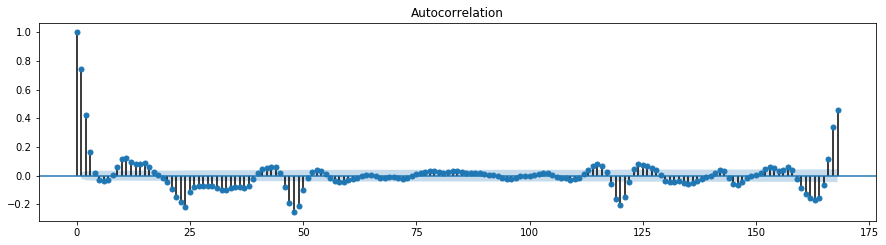

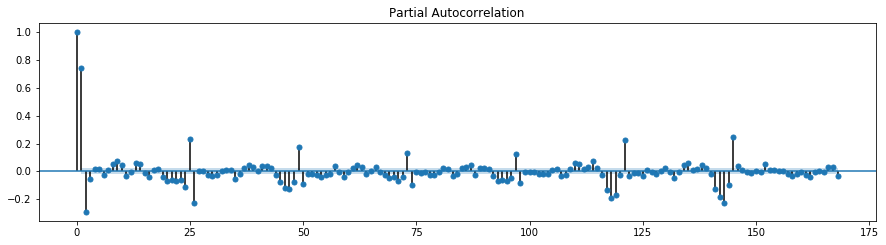

In [153]:
for n in range(n_clusters):
    plot_acf_pacf(residuals_diff24[n])

Параметры возьмём приближёнными для скорости (увы времени сейчас мало), но в ущерб качеству

In [154]:
from itertools import product

hyper_params = []

hyper_params.append({'p':1, 'q':2, 'P':1, 'Q':1})
hyper_params.append({'p':1, 'q':2, 'P':1, 'Q':1})
hyper_params.append({'p':1, 'q':2, 'P':1, 'Q':1})

### 5.Построение модели

In [155]:
%%time

models = []

for n in range(n_clusters):
    ps = range(0, hyper_params[n]['p']+1)
    d=0 # одно обычное дифференцирование
    qs = range(0, hyper_params[n]['q']+1)
    Ps = range(0, hyper_params[n]['P']+1)
    D=1 # одно сезонное дифференцирование
    Qs = range(0, hyper_params[n]['Q']+1)

    parameters = product(ps, qs, Ps, Qs)
    parameters_list = list(parameters)
    print(len(parameters_list))
    

    results = []
    best_aic = float("inf")
    warnings.filterwarnings('ignore')
    
    #Возьмем данные за апрель, так же из-за времени
    residuals4model = residuals[n].loc['2016-03-30 00:00:00':'2016-04-30 23:00:00', 'residuals']

    for param in parameters_list:
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(residuals4model,  
                                            order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)


        except ValueError:
                 print('wrong parameters:', param)
                 continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param

    warnings.filterwarnings('default')


    models.append(best_model)   

24
wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 1, 0, 0)
wrong parameters: (0, 1, 0, 1)
wrong parameters: (0, 1, 1, 0)
wrong parameters: (0, 1, 1, 1)
wrong parameters: (0, 2, 1, 0)
wrong parameters: (0, 2, 1, 1)
24
wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 2, 1, 0)
wrong parameters: (0, 2, 1, 1)
24
wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 2, 1, 0)
wrong parameters: (0, 2, 1, 1)
Wall time: 14min 18s


In [156]:
# for n in range(n_clusters):
#     with open('models/model_residuals_%d.pkl'%n, 'wb') as model_pkl:
#          pickle.dump(models[n], model_pkl)    
    

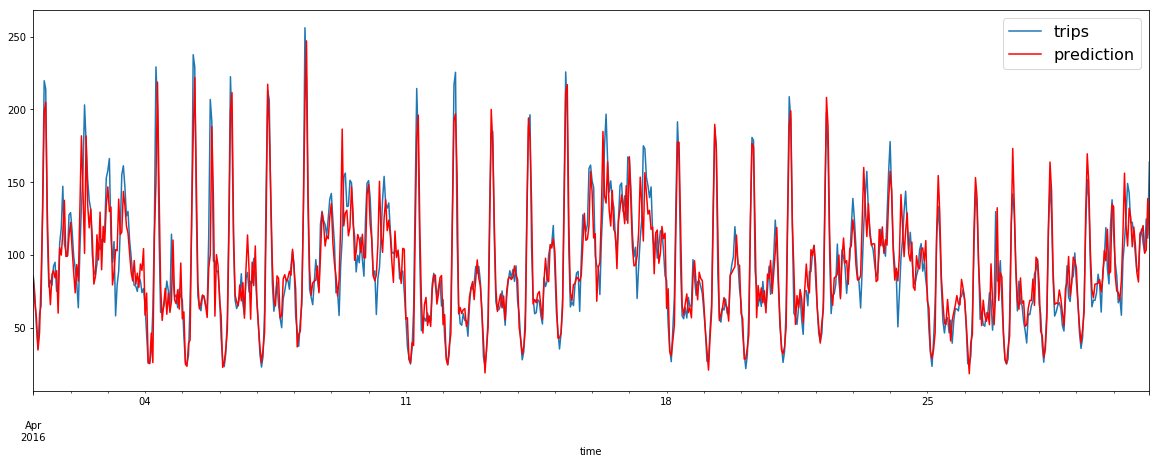

In [157]:
# проверка модели
cluster = 2
begin_time = '2016-04-01 00:00:00'
end_time = '2016-04-30 23:00:00'
cl_center = df_cluster_centers.loc[begin_time:end_time , 'cluster%d'%cluster]
df = pd.DataFrame(cl_center * norm_mean_std[cluster][1] + norm_mean_std[cluster][0])
df.columns = ['trips'] 
df['prediction'] = (models[cluster].fittedvalues.loc[begin_time:end_time].values + 
                    predictions[cluster].loc[begin_time:end_time].predictions) * norm_mean_std[cluster][1] + norm_mean_std[cluster][0]

plt.figure(figsize=(20,7))
df.trips.plot()
df['prediction'].plot(color = 'r')
plt.legend(loc=1,prop={'size':16})
plt.show()

### 6.Прогнозизование и ошибки модели

In [158]:
def calc_mae(history_ends, hours, df_predictions):

    results = []
    region_sum = 0
    
    for index, r in enumerate(region_columns):
        region_name = r
        
        #получаем номер кластера, соответствующего региону
        region_cluster = int(data_normed_T.loc[region_name, 'cluster'])
        
        mean = norm_mean_std[index][0]
        std = norm_mean_std[index][1]
        
        # модель для региона с соотвествующими парметрами кластера
        data_r = data_normed.loc['2016-04-01 00:00:00':history_ends[0],r]
        model_r = sm.tsa.statespace.SARIMAX(data_r,  
                                            order=(1,0,2), 
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,
                                            seasonal_order=(1,1,1, 24)).filter(models[region_cluster].params) 
    
        df_region_hat = model_r.predict(str(history_ends[0]), str(history_ends[-1]))

        df_region_hat = df_region_hat - df_region_hat.mean()
        
        hist_sum = 0

        for h in range(1, (hours + 1)):

                label = history_ends[h-1]
                start_time = datetime.strptime(str(history_ends[0]), "%Y-%m-%d %H:%M:%S") + timedelta(hours=h)
                end_time = start_time + timedelta(hours=5)
                
                y = data_normed.loc[start_time:end_time, region_name].values  

                y_hat = df_region_hat.loc[start_time:end_time].values
                
                preds = df_predictions[region_cluster].loc[start_time:end_time].predictions.values
                y_hat2 = (y_hat + preds)
                
                for h in range(0,6):
                    #kaggle
                    results.append([
                            "%s_%d-%02d-%02d_%d_%d" %  (r, label.year, label.month, label.day, label.hour, (h+1)),
                            y_hat2[h] * std + mean,
                            y[h] * std + mean])
                              
                y_sum = np.abs((y_hat2 * std + mean) - (y * std + mean)).sum()
                hist_sum += y_sum

        region_sum += hist_sum
        print (r, region_cluster, hist_sum)

    #считаем общую ошибку
    return region_sum / (102 * hours * 6), results

In [159]:
%%time
df_raw_may = data_normed.loc['2016-04-30 23:00:00': '2016-05-31 23:00:00']
may_hist_ends = list(df_raw_may.index)

mae_may, results_may = calc_mae(may_hist_ends, 739, predictions)


1075 0 63670.1676582
1076 0 120747.788276
1077 0 100455.100563
1125 0 69733.0881117
1126 0 159621.32725
1127 0 279402.256589
1128 1 318323.091219
1129 1 386252.646892
1130 1 423735.520579
1131 0 176790.613924
1132 0 82530.6964269
1172 2 15040.5828427
1173 2 41892.8922085
1174 2 41734.3832576
1175 2 24460.569478
1176 1 27477.1258393
1177 1 394320.306516
1178 1 435104.609599
1179 0 395259.317969
1180 0 460489.070116
1181 0 629832.148849
1182 2 378136.563508
1183 0 123293.614476
1184 0 27072.4416722
1221 1 12462.3942287
1222 1 20765.3609067
1223 1 31837.3500494
1224 2 33360.3003959
1225 2 12182.294896
1227 1 258082.382333
1228 1 416621.813068
1229 0 451135.488986
1230 0 625536.046559
1231 0 520801.013136
1232 0 531546.852294
1233 0 418605.924766
1234 0 284243.655147
1235 0 123502.725306
1272 1 16170.1907751
1273 1 30499.1685119
1274 1 14978.2573952
1278 2 21010.5441016
1279 0 34169.3600697
1280 0 160197.609617
1281 0 517920.234933
1282 0 748839.589474
1283 0 206516.129214
1284 0 90408.922

In [160]:
print(mae_may)

33.2885671319


In [161]:
%%time

df_raw_june = data_normed.loc['2016-05-31 23:00:00': '2016-06-30 23:00:00']
june_hist_ends = list(df_raw_june.index)
mae_june, results_june = calc_mae(june_hist_ends, 715, predictions)

print(mae_june)

1075 0 67604.2253761
1076 0 98268.2517721
1077 0 81173.1889647
1125 0 57196.8770259
1126 0 136709.183552
1127 0 207538.151022
1128 1 267681.041437
1129 1 336345.333352
1130 1 376051.410832
1131 0 153030.939734
1132 0 72067.6083158
1172 2 10644.9689609
1173 2 31287.9130751
1174 2 34378.3050789
1175 2 20918.1123873
1176 1 24394.8351384
1177 1 316976.535191
1178 1 433322.446691
1179 0 356509.677681
1180 0 386850.649216
1181 0 548918.223771
1182 2 368748.311239
1183 0 109637.4261
1184 0 22751.9084888
1221 1 11264.6313201
1222 1 16893.103674
1223 1 23528.0920676
1224 2 28054.5877493
1225 2 10918.9362645
1227 1 212319.471629
1228 1 356859.452778
1229 0 393498.612509
1230 0 504728.414281
1231 0 511764.00978
1232 0 442903.983098
1233 0 312744.297163
1234 0 224897.488719
1235 0 99639.3105407
1272 1 14299.260527
1273 1 24442.8006682
1274 1 11600.9047314
1278 2 17760.3446544
1279 0 29949.1965299
1280 0 138870.169439
1281 0 436244.81037
1282 0 631185.198649
1283 0 175091.878521
1284 0 78246.251162

In [162]:
df = pd.DataFrame(results_june)
df.columns = [['id','y','y_true']]
df = df.set_index('id')
df.drop(['y_true'], axis = 1, inplace=True)
df.to_csv('submit_1.csv')

Ссылка на сабмит:
https://inclass.kaggle.com/c/yellowtaxi/leaderboard?submissionId=4929254
        